In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from torch.nn import LayerNorm

In [15]:
!pip install thop
!pip install tdqm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Part 1: Attention and Encoder-Decoder Models

In this section, you'll implement two forms of attention and use them in an encoder-decoder style transformer. You'll then compare performance based on changing dataset size and hidden dimension.

## Step 1: Scaled Dot Product Attention
Implement both the base `scaled_dot_attention` method as well as the `forward` method for the `Attention` module.

In [16]:
def scaled_dot_attention(q, k, v, mask=0):
  """Computes scaled dot product attention with an optional mask.
    q : shape ( batch, k, hidden_size)
    k : shape ( batch, seq_len, hidden_size)
    v : shape ( batch, seq_len, hidden_size)
    mask: optional. shape (k, seq_len)

  returns:
      context   : shape (batch, k, hidden_size)
      attention : shape (batch, k, seq_len)
  """

  # ------------
  # FILL THIS IN
  # ------------
  # unnorm_attn = 
  # masked_unnorm_attn =
  # attention =
  # context =
  unnorm_attn = (q @ k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
  masked_unnorm_attn = unnorm_attn + mask
  attention = torch.nn.functional.softmax(masked_unnorm_attn, dim=-1)
  context = attention @ v

  return context, attention

In [17]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.Q = nn.Linear(hidden_size, hidden_size, bias=False)
        self.K = nn.Linear(hidden_size, hidden_size, bias=False)
        self.V = nn.Linear(hidden_size, hidden_size, bias=False)
        self.hidden_size = hidden_size

    def forward(self, x, annots):
        #   x         : shape ( batch, k, hidden_size)
        #   annots    : shape ( batch, seq_len, hidden_size)

        # ------------
        # FILL THIS IN
        # Pay attention to which inputs you use for the queries, keys, and values.
        # ------------
        # q =
        # k =
        # v =
        q = self.Q(x)
        k = self.K(annots)
        v = self.V(annots)

        return scaled_dot_attention(q, k, v)

## Step 2: Causal Scaled Dot Product Attention
Using your `scaled_dot_attention` method, implement the `forward` method for the `CausalAttention` module.


In [18]:
class CausalAttention(Attention):
    def __init__(self, hidden_size):
        super().__init__(hidden_size)

    def forward(self, x):
        #   x : shape ( batch, seq_len, hidden_size)

        # ------------
        # FILL THIS IN
        # This should be very similar to your other attention implementation,
        # with the exception that you only have one set of outputs and you
        # must construct a causal attention mask.
        # ------------
        # q =
        # k =
        # v =
        # mask =
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)
        seq_len = x.size(1)
        mask = torch.triu(torch.full((seq_len, seq_len), float('-inf'), device=x.device), diagonal=1)
        return scaled_dot_attention(q, k, v, mask)


#### Simple test cases
##### Passing this DOES NOT mean your implementation is correct. But, if this fails, then you definitely did something wrong

In [19]:
cros_attn = Attention(32)
caus_attn = CausalAttention(32)
caus_attn.Q = cros_attn.Q
caus_attn.K = cros_attn.K
caus_attn.V = cros_attn.V

inp = torch.randn(4, 8, 32)
inp2 = torch.randn(4, 16, 32)

print("Checking consistent shape")
assert cros_attn(inp, inp2)[0].shape == inp.shape
assert caus_attn(inp)[0].shape == inp.shape
assert cros_attn(inp, inp2)[1].shape == (4, 8, 16)
assert caus_attn(inp)[1].shape == (4, 8, 8)

print("Checking attention mask")
assert torch.all(caus_attn(inp)[0][:, -1] == cros_attn(inp, inp)[0][:, -1])

print("Passed")

Checking consistent shape
Checking attention mask
Passed


#### Read through the following code. Make sure you understand what is going on.
This code sets up the encoder-decoder architecture. It requires no additional code.

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len = 1000):
        super().__init__()

        pos = torch.arange(max_len).float().unsqueeze(1)
        dim = torch.arange(hidden_size // 2).float().unsqueeze(0)

        div_term = torch.exp(-math.log(10000.0) * (2 * dim) / hidden_size)
        angle = pos * div_term

        pe = torch.zeros(max_len, hidden_size)
        pe[:, 0::2] = torch.sin(angle)
        pe[:, 1::2] = torch.cos(angle)

        self.register_buffer("pe", pe)

    def forward(self, idx):
        return self.pe[idx]

In [21]:
class MLP(nn.Module):

    def __init__(self, hidden_size):
        super().__init__()
        self.layer1  = nn.Linear(hidden_size, hidden_size, bias=False)
        self.layer2  = nn.Linear(hidden_size, hidden_size, bias=False)
        self.relu    = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.norm1 = LayerNorm(hidden_size)
        self.norm2 = LayerNorm(hidden_size)
        self.attn = Attention(hidden_size)
        self.mlp = MLP(hidden_size)

    def forward(self, x):
        context, attention = self.attn(self.norm1(x), self.norm1(x))
        x = x + context
        x = x + self.mlp(self.norm2(x))
        return x, attention

class DecoderBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.norm1 = LayerNorm(hidden_size)
        self.norm2 = LayerNorm(hidden_size)
        self.cros_attn = Attention(hidden_size)
        self.self_attn = CausalAttention(hidden_size)
        self.mlp = MLP(hidden_size)

    def forward(self, x, annotation):
        context, self_attn = self.self_attn(self.norm1(x))
        x = x + context
        context, cros_attn = self.cros_attn(self.norm2(x), annotation)
        x = x + context
        x = x + self.mlp(self.norm2(x))
        return x, self_attn, cros_attn

In [22]:


class TransformerEncoderDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, hidden_size)
        self.pos_emb = PositionalEncoding(hidden_size)

        self.encoder_blocks = nn.ModuleList(
            [EncoderBlock(hidden_size) for i in range(num_layers)]
        )
        self.decoder_blocks = nn.ModuleList(
            [DecoderBlock(hidden_size) for i in range(num_layers)]
        )

        self.head = nn.Linear(hidden_size, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight
        # weight tie, the final layer reuses the weights of the embedding layers
        # this reduces the total number of parameters

        self.apply(self._init_weights) # initialize the weights to a small number

    def forward(self, inputs, annots):

        pos_x = torch.arange(0, inputs.shape[-1], device=inputs.device).long() # creates tensor([0, 1, 2, 3, ...])
        pos_y = torch.arange(0, annots.shape[-1], device=inputs.device).long() # creates tensor([0, 1, 2, 3, ...])

        x = self.tok_emb(inputs) + self.pos_emb(pos_x)
        y = self.tok_emb(annots) + self.pos_emb(pos_y)

        self_attn = []
        cros_attn = []

        for encode in self.encoder_blocks:
            y, _ = encode(y)

        for decode in self.decoder_blocks:
            x, s, c = decode(x, y)
            cros_attn.append(c)
            self_attn.append(s)

        return self.head(x), {'self_attn': self_attn, 'cros_attn': cros_attn}

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

## Step 3: Training the model

You'll now train a set of example models. This section requires no additional code from you, with the exception of setting the datapath. However, **you are required to analyze and include some of its output**.

In [23]:
from dataset import EncoderDecoderDataset, DecoderDataset
from utils import save_loss_comparison_by_dataset, save_loss_comparison_by_hidden
from torch.utils.data import DataLoader
from trainer import train
import torch.optim as optim

data_path = './' # Change data_path to where the data is stored

encdec_ds_small = EncoderDecoderDataset(data_path, 'pig_latin_small')
encdec_ds_large = EncoderDecoderDataset(data_path, 'pig_latin_large')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [24]:
print("Dataset sample:")
print("Input:", encdec_ds_small.to_token(encdec_ds_small[0][0].tolist()))
print("Annotation:", encdec_ds_small.to_token(encdec_ds_small[0][1].tolist()))
print("Target:", encdec_ds_small.to_token(encdec_ds_small[0][2].tolist()))

Dataset sample:
Input: <SOS>ailsay
Annotation: sail
Target: ailsay<EOS>


In [ ]:
model = TransformerEncoderDecoder(
    vocab_size = len(encdec_ds_small.idx_to_token),
    hidden_size = 16,
    num_layers = 4
)

optimizer = optim.AdamW(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

results = train(
    model=model,
    dataset=encdec_ds_small,
    num_epochs=25,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,z
    batch_size = 32
)

Epoch 1 | Train loss: 2.559865 | Val loss 2.234298
Epoch 2 | Train loss: 2.137779 | Val loss 1.993408
Epoch 3 | Train loss: 1.900302 | Val loss 1.823090
Epoch 4 | Train loss: 1.623885 | Val loss 1.467871
Epoch 5 | Train loss: 1.255784 | Val loss 0.951591
Epoch 6 | Train loss: 0.819798 | Val loss 0.583012
Epoch 7 | Train loss: 0.566873 | Val loss 0.578609
Epoch 8 | Train loss: 0.394831 | Val loss 0.306928
Epoch 9 | Train loss: 0.290097 | Val loss 0.303816
Epoch 10 | Train loss: 0.258981 | Val loss 0.240161
Epoch 11 | Train loss: 0.214482 | Val loss 0.205589
Epoch 12 | Train loss: 0.185541 | Val loss 0.198773
Epoch 13 | Train loss: 0.162352 | Val loss 0.168676
Epoch 14 | Train loss: 0.132555 | Val loss 0.174729
Epoch 15 | Train loss: 0.111718 | Val loss 0.120178
Epoch 16 | Train loss: 0.101541 | Val loss 0.119085
Epoch 17 | Train loss: 0.094665 | Val loss 0.128726
Epoch 18 | Train loss: 0.085573 | Val loss 0.178565
Epoch 19 | Train loss: 0.083787 | Val loss 0.109064
Epoch 20 | Train loss

In [26]:
def encdec_generate(input, model, dataset, max_len=20):
    gen_string = ""
    idx = torch.tensor([[dataset.start_idx]]).to(device)
    annots = torch.tensor([dataset.to_idx(input) + [dataset.end_idx]*(max(0, 12-len(input)))]).to(device)
    #pad the input string with <EOS> since the collate_fn had to pad the stirngs

    for i in range(max_len):
        logits = model(idx, annots)[0]

        token_idx = logits[0, -1:].argmax(dim=-1)
        idx = torch.cat([idx, token_idx.unsqueeze(0)], dim=1)

        if token_idx.item() == dataset.end_idx:
            break
        else:
            gen_string = gen_string + dataset.idx_to_token[token_idx.item()]
    return gen_string

def encdec_translate(sentence, model, dataset):
    words = sentence.split()
    return " ".join([encdec_generate(w, model, dataset) for w in words])

In [27]:
encdec_translate('the', model, encdec_ds_small)

'ethay'

In [28]:
encdec_translate("the air conditioning is working", model, encdec_ds_small)

'ethay airway onditioningcay isway orkingway'

In [29]:
encdec_translate("testing some random words", model, encdec_ds_small)

'estingtay omesay andomray ordsway'


Training model: hidden_size=16, dataset=small
Epoch 1 | Train loss: 2.614822 | Val loss 2.272956
Epoch 2 | Train loss: 2.147061 | Val loss 2.041627
Epoch 3 | Train loss: 1.941660 | Val loss 1.816681
Epoch 4 | Train loss: 1.703522 | Val loss 1.619526
Epoch 5 | Train loss: 1.436208 | Val loss 1.219059
Epoch 6 | Train loss: 1.097793 | Val loss 0.891540
Epoch 7 | Train loss: 0.746915 | Val loss 0.563707
Epoch 8 | Train loss: 0.548483 | Val loss 0.461585
Epoch 9 | Train loss: 0.409685 | Val loss 0.383879
Epoch 10 | Train loss: 0.304081 | Val loss 0.277446
Epoch 11 | Train loss: 0.240158 | Val loss 0.209440
Epoch 12 | Train loss: 0.227271 | Val loss 0.158160
Epoch 13 | Train loss: 0.165968 | Val loss 0.242059
Epoch 14 | Train loss: 0.150513 | Val loss 0.176731
Epoch 15 | Train loss: 0.124279 | Val loss 0.115422
Epoch 16 | Train loss: 0.121866 | Val loss 0.106445
Epoch 17 | Train loss: 0.117356 | Val loss 0.202675
Epoch 18 | Train loss: 0.106425 | Val loss 0.086973
Epoch 19 | Train loss: 0.0

<Figure size 432x288 with 0 Axes>

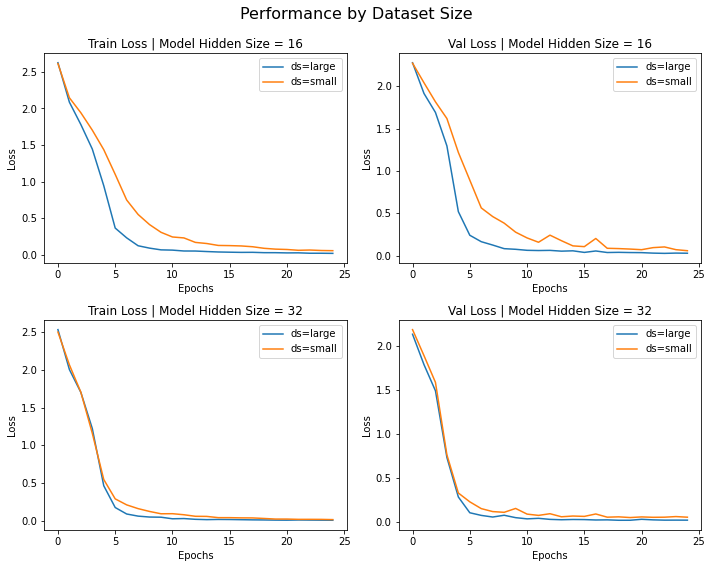

<Figure size 432x288 with 0 Axes>

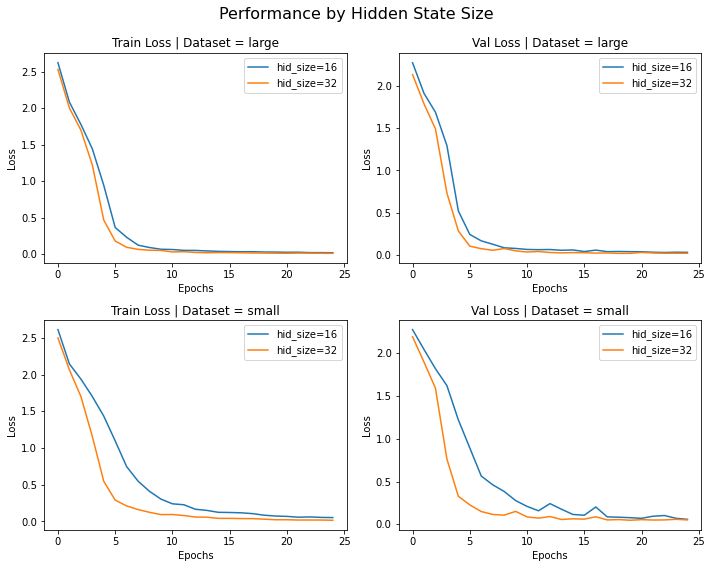

In [30]:
configs = [
    (16, 'small', encdec_ds_small),
    (16, 'large', encdec_ds_large),
    (32, 'small', encdec_ds_small),
    (32, 'large', encdec_ds_large)
]

all_results = {}

for hidden_size, dataset_name, dataset in configs:
    print(f"\nTraining model: hidden_size={hidden_size}, dataset={dataset_name}")

    model = TransformerEncoderDecoder(
        vocab_size=len(dataset.idx_to_token),
        hidden_size=hidden_size,
        num_layers=4
    )
    optimizer = optim.AdamW(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    results = train(
        model = model,
        dataset = dataset,
        num_epochs = 25,
        optimizer = optimizer,
        scheduler = scheduler,
        device = device,
        batch_size = 32 if dataset_name == "small" else 256
    )
    all_results[(hidden_size, dataset_name)] = results

save_loss_comparison_by_dataset(all_results)
save_loss_comparison_by_hidden(all_results)

# Part 2: Decoder-only Transformers and Multi-Head Attention

In this section, you'll train transformers that only use a decoder instead of a dual encoder-decoder architecture. You'll also implement and experiment with multi-head attention. Finally, you'll compare increasing parameter count with multi-head attention vs. increasing the parameter count with a larger hidden dimensionality.

## Step 1: Implement the Decoder-Only Forward Method

In [31]:
class DecoderOnlyBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.norm1 = LayerNorm(hidden_size)
        self.norm2 = LayerNorm(hidden_size)
        self.attn = CausalAttention(hidden_size)
        self.mlp = MLP(hidden_size)

    def forward(self, x):
        context, attention = self.attn(self.norm1(x))
        x = x + context
        x = x + self.mlp(self.norm2(x))
        return x, attention

class DecoderTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, hidden_size)
        self.pos_emb = PositionalEncoding(hidden_size)

        self.blocks = nn.ModuleList(
            [DecoderOnlyBlock(hidden_size) for i in range(num_layers)]
        )
        self.head = nn.Linear(hidden_size, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight
        # weight tie, the final layer reuses the weights of the embedding layers
        # this reduces the total number of parameters

    def forward(self, inputs):
        """Forward pass of the Transformer decoder.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """
        # ------------
        # FILL THIS IN
        # ------------
        # pos =
        # x =
        # self_attn = []

        # for block in self.blocks:
        #     ...
        #
        # unormalized_scores =

        pos = torch.arange(0, inputs.shape[1], device=inputs.device)
        x = self.tok_emb(inputs) + self.pos_emb(pos)
        self_attn = []

        for block in self.blocks:
            x, attention = block(x)
            self_attn.append(attention)

        unormalized_scores = self.head(x)

        return unormalized_scores, {'self_attn': self_attn}

In [32]:
decoder_ds_small = DecoderDataset(data_path, 'pig_latin_small')
decoder_ds_large = DecoderDataset(data_path, 'pig_latin_large')

In [33]:
print("Dataset sample:")
print("Input:", decoder_ds_small.to_token(decoder_ds_small[0][0].tolist()))
print("Target:", decoder_ds_small.to_token(decoder_ds_small[0][1].tolist()))

Dataset sample:
Input: <SOS>sail<EOP>ailsay
Target: sail<EOP>ailsay<EOS>


## Step 2: Format for decoder-only generation.

Implement the missing line in `decoder_generate` to create an input string that looks like:

```
<SOS> input sequence <EOP>
```
You should use the `dataset.start_idx`, `dataset.eop_idx` attributes and the `dataset.to_idx()` method.

In [34]:
def decoder_generate(input, model, dataset, max_len=20):
    gen_string = ""
    idx = [dataset.start_idx] + dataset.to_idx(input) + [dataset.eop_idx]
    idx = torch.tensor([idx]).to(device)

    for i in range(max_len):
        logits = model(idx)[0]

        token_idx = logits[0, -1:].argmax(dim=-1)
        idx = torch.cat([idx, token_idx.unsqueeze(0)], dim=1)

        if token_idx.item() == dataset.end_idx:
            break
        else:
            gen_string = gen_string + dataset.idx_to_token[token_idx.item()]
    return gen_string

def decoder_translate(sentence, model, dataset):
    words = sentence.split()
    return " ".join([decoder_generate(w, model, dataset) for w in words])

## Step 3: Train the model

We'll now train a decoder only model and test it out on an example. Use the output of this to guide your answer for question 3.

In [35]:
model = DecoderTransformer(
    vocab_size = len(decoder_ds_small.idx_to_token),
    hidden_size = 16,
    num_layers = 4
)

optimizer = optim.AdamW(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

results = train(
    model = model,
    dataset = decoder_ds_small,
    num_epochs = 25,
    optimizer = optimizer,
    scheduler = scheduler,
    device = device,
    batch_size = 32
)

Epoch 1 | Train loss: 3.194438 | Val loss 1.829255
Epoch 2 | Train loss: 1.689661 | Val loss 1.496791
Epoch 3 | Train loss: 1.401202 | Val loss 1.293152
Epoch 4 | Train loss: 1.151498 | Val loss 1.021778
Epoch 5 | Train loss: 0.887198 | Val loss 0.816906
Epoch 6 | Train loss: 0.687766 | Val loss 0.618331
Epoch 7 | Train loss: 0.557265 | Val loss 0.496170
Epoch 8 | Train loss: 0.469965 | Val loss 0.481124
Epoch 9 | Train loss: 0.418389 | Val loss 0.461549
Epoch 10 | Train loss: 0.367821 | Val loss 0.352982
Epoch 11 | Train loss: 0.324807 | Val loss 0.407131
Epoch 12 | Train loss: 0.288770 | Val loss 0.315346
Epoch 13 | Train loss: 0.278562 | Val loss 0.296515
Epoch 14 | Train loss: 0.250052 | Val loss 0.266891
Epoch 15 | Train loss: 0.228068 | Val loss 0.288948
Epoch 16 | Train loss: 0.238552 | Val loss 0.214725
Epoch 17 | Train loss: 0.193680 | Val loss 0.230534
Epoch 18 | Train loss: 0.186382 | Val loss 0.209010
Epoch 19 | Train loss: 0.179733 | Val loss 0.249936
Epoch 20 | Train loss

In [36]:
decoder_translate("the air conditioning is working", model, decoder_ds_small)

'ethay airway onditioningcay isway orkingway'

## Step 4: Implement Multi-Head Attention

In this next step, you'll implement multi-head attention. In this setting, we'll have the dimensionality for each of the heads be (total hidden dimensionality)/(number of heads). We'll use a projection head to combine the outputs of these different attention heads after concatenating their outputs together (which can also be achieved using tensor reshaping).

In [42]:


# TO DO:

def multihead_scaled_dot_attention(q, k, v, mask=0):
    """ Compute multi-head dot product attention.
      q : shape (batch, num_heads, k, hidden_size)
      k : shape (batch, num_heads, seq_len, hidden_size)
      v : shape (batch, num_heads, seq_len, hidden_size)

    returns:
        context   : shape (batch, num_heads, k, hidden_size)
        attention : shape (batch, num_heads, k, seq_len)
    """
    # Hint: if you implemented scaled_dot_attention well, the code for this should be the exact same.

    # ------------
    # FILL THIS IN
    # ------------
    # unnorm_attn =
    # masked_unnorm_attn =
    # attention =
    # context =
    unnorm_attn = (q @ k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
    masked_unnorm_attn = unnorm_attn + mask
    attention = torch.nn.functional.softmax(masked_unnorm_attn, dim=-1)
    context = attention @ v
    return context, attention

In [ ]:
class MultiheadCausalAttention(Attention):
    def __init__(self, hidden_size, num_heads):
        super().__init__(hidden_size)
        # self.Q, self.K, self.V already defined as nn.Linear(hidden_size, hidden_size)
        self.num_heads = num_heads
        # ------------
        # FILL THIS IN
        # ------------
        # if self.num_heads > 1:
        #   self.proj = nn.Linear( ,  , bias=False)
        if self.num_heads > 1:
          self.proj = nn.Linear(hidden_size, hidden_size, bias=False)


    def forward(self, x):

        """ Compute causal multi-head dot product attention from an input sequence.
          x : shape ( batch, seq_len, hidden_size)
          k : shape (batch, num_heads, seq_len, hidden_size)
          v : shape (batch, num_heads, seq_len, hidden_size)

        returns:
            context : shape ( batch, seq_len, hidden_size)
            attention : shape (batch, num_heads, k, seq_len)
        """
        # ------------
        # FILL THIS IN
        # ------------
        # unnorm_attn =
        # masked_unnorm_attn =
        # attention =
        # context =

        # B, T, C = x.size()
        # q = self.Q(x).view( ,  ,  ,  ).transpose(1, 2)
        # k = self.K(x).view( ,  ,  ,  ).transpose(1, 2)
        # v = self.V(x).view( ,  ,  ,  ).transpose(1, 2)

        # mask =

        # context, attention = multihead_scaled_dot_attention(q, k, v, mask)

        # Hint: you may find the .transpose(), .contiguous(), and .view()
        # methods helpful for creating the reshaped context.

        # reshaped_context =


        # Only perform a projection if the number of heads is more than 1.
        if self.num_heads > 1:

          return self.proj(reshaped_context), attention

        else:

          return reshaped_context, attention

In [39]:
class MultiheadDecoderBlock(DecoderOnlyBlock):
    def __init__(self, hidden_size, num_heads):
        super().__init__(hidden_size)
        self.attn = MultiheadCausalAttention(hidden_size, num_heads)


class MultiheadDecoderTransformer(DecoderTransformer):
    def __init__(self, vocab_size, hidden_size, num_layers, num_heads):
        super().__init__(vocab_size, hidden_size, num_layers)
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.blocks = nn.ModuleList(
            [MultiheadDecoderBlock(hidden_size, num_heads) for i in range(num_layers)]
        )

## Step 5: Compare Parameter Usage Methods

Here, you'll train 5 models with varying numbers of attention heads and hidden dimensionalities. You'll compare their parameter efficiency. Start by implementing the `calc_parameters_decoder` method, and then run the code to train the models.

In [40]:
def calc_parameters_decoder(model):
  # ------------
  # FILL THIS IN
  # ------------
  # params = TODO # embedding
  # params +=  TODO # QKV linear projections
  # if model.num_heads > 1:
  #   params += TODO # attention linear projection
  # params += TODO # MLP linear
  # params += TODO # layer norms Hint: LayerNorm(x) uses x parameters

  # Hint: Read the code carefully:
  # params += TODO # head 

  return params


In [41]:
import matplotlib.pyplot as plt
import numpy as np
configs = [
    (16, 4, 4, 64), #(hidden_size, num_heads, num_layers, batch_size)
    (16, 2, 4, 64),
    (16, 1, 4, 64),
    (24, 1, 4, 64),
    (32, 1, 4, 64),
]

all_results = {}

for hidden_size, num_heads, num_layers, batch_size in configs:
    print(f"\nTraining model: hidden_size={hidden_size}, num_heads={num_heads}, num_layers={num_layers}")

    model = MultiheadDecoderTransformer(
        vocab_size = len(decoder_ds_large.idx_to_token),
        hidden_size = hidden_size,
        num_layers = num_layers,
        num_heads = num_heads
    )

    optimizer = optim.AdamW(model.parameters(), lr=5e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    results = train(
        model = model,
        dataset = decoder_ds_large,
        num_epochs = 25,
        optimizer = optimizer,
        scheduler = scheduler,
        device = device,
        batch_size = batch_size
    )

    parameters = calc_parameters_decoder(model)
    x_points = np.linspace(0, len(results['val_loss']), len(results['val_loss']))
    plt.plot(
        x_points, results['val_loss'], label="heads = {}, dim={}, params={}".format(
            num_heads, hidden_size, parameters
        ))
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title('Compute Optimal Models')
plt.grid()
plt.legend()
plt.show()


Training model: hidden_size=16, num_heads=4, num_layers=4


AttributeError: 'MultiheadCausalAttention' object has no attribute 'proj'

In [ ]:
plt.clf()

# Part 3: IsoFLOP Profiling and Scaling Laws
In this final section, you'll compare different architectures based on their compute efficiency. You will also determine the optimal number of parameters and tokens for a fixed compute budget.

While this section does not require any additional code from you, **use the output of it to guide your written responses**.

In [ ]:
from utils import (
    plot_scaling_law,
    plot_scaling_law_poly,
    interpolate,
    plot_flops_tokens,
    plot_isoflop,
    plot_flops_params
)

import numpy as np

## Step 1: Train models, Compare FLOPS vs Validation Loss

We'll inspect the compute efficiency of different models by plotting their validation loss against the number of FLOPs used in training up to that point.

In [ ]:

configs = [
    (40, 2, 4, 256), #(hidden_size, num_heads, num_layers, batch_size)
    (32, 2, 4, 128),
    (24, 2, 4, 64),
    (16, 1, 4, 64),
    (16, 1, 3, 64),
    (12, 1, 3, 64),
    (12, 1, 2, 64),
]

all_results = {}

for hidden_size, num_heads, num_layers, batch_size in configs:
    print(f"\nTraining model: hidden_size={hidden_size}, num_heads={num_heads}, num_layers={num_layers}")

    model = MultiheadDecoderTransformer(
        vocab_size = len(decoder_ds_large.idx_to_token),
        hidden_size = hidden_size,
        num_layers = num_layers,
        num_heads = num_heads
    )

    optimizer = optim.AdamW(model.parameters(), lr=5e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    results = train(
        model = model,
        dataset = decoder_ds_large,
        num_epochs = 25,
        optimizer = optimizer,
        scheduler = scheduler,
        device = device,
        batch_size = batch_size
    )

    parameters = calc_parameters_decoder(model)
    all_results[parameters] = results


In [ ]:
plot_scaling_law(all_results)

plot_scaling_law_poly(all_results)

## Step 2: Optimal Number of Parameters

Using the previously created training runs, we'll fit quadratic functions to the (parameter count, validation loss) pairs to estimate the optimal number of parameters for a given compute budget. We'll then fit a line to this set of optimal parameters to estimate the optimal number of parameters for a compute budget of 1e15.

In [ ]:
def find_optim_params(params, loss):
    x = np.array(params)
    y = np.array(loss)

    p = np.polyfit(np.log10(x), y, 2)
    optimal_log_params = -(p[1]) / (2 * p[0])
    optimal_params = 10**(optimal_log_params)

    return optimal_params


target_flops = [8e9, 16e9, 32e9, 64e9, 128e9]
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00']
params_vs_loss = []
optimal_params = []

for target in target_flops:
  parameters = []
  val_loss = []

  for params, results in all_results.items():
    loss = interpolate(results['val_loss'], results['flops'], target, deg=4)
    # interpolate returns None if target is out of range
    if loss != None:
      parameters.append(params)
      val_loss.append(loss)

  sorted_indices = torch.argsort(torch.tensor(parameters))
  parameters = torch.tensor(parameters)[sorted_indices]
  val_loss = torch.tensor(val_loss)[sorted_indices]

  optimal_params.append(find_optim_params(parameters, val_loss))
  params_vs_loss.append((parameters.tolist(), val_loss.tolist()))


In [ ]:
plot_isoflop(target_flops, colors, params_vs_loss, optimal_params)

In [ ]:
plot_flops_params(target_flops, optimal_params)

## Step 3: Optimal Number of Tokens

Finally, we'll perform a similar analysis to the previous step, only this time determining the optimal number of tokens for a budget of 1e15 flops.

In [ ]:
plot_flops_tokens(target_flops, optimal_params, all_results)